In [3]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import time

pd.options.display.width = 1200
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100
pd.options.display.max_rows = 67

In [232]:
data = pd.read_pickle("data_combined")

In [75]:
X = data.drop(columns='Class')
y = data["Class"]

state = 42
folds = 8
kf = KFold(folds, True, state).split(X)
split = []
for x in range(folds):
    split.append(next(kf, None))

In [6]:
def split_data(X,y):

    global X_tn
    global X_tt
    global y_tn
    global y_tt

    X_tn = []
    X_tt = []
    y_tn = []
    y_tt = []
    
    for x in range(folds):
        X_tn.append(X.iloc[split[x][0]])
        X_tt.append(X.iloc[split[x][1]])
        y_tn.append(y.iloc[split[x][0]])
        y_tt.append(y.iloc[split[x][1]])

In [15]:
def model_results(m, s = None, d= True, i = 0):
    if d==True:
        print("Training",m)
    t_start = time.time()
    best = -1
    y_pred_ts = []
    y_pred_tt = []
    
    if s == None:
        for x in range(folds):
            
            model = m
            model.fit(X_tn[x], y_tn[x])
            
            y_pred_training = model.predict(X_tn[x])
            y_pred_test = model.predict(X_tt[x])
            
            f1_scr = f1_score(y_tt[x], y_pred_test, pos_label="Positive")

            if best<f1_scr:
                fold = x
                best = f1_scr
                y_pred_tt = y_pred_test
                y_pred_tn = y_pred_training

        best_fold[i].append(fold)
        
        f1[i].append(f1_score(y_tt[fold],y_pred_tt, pos_label="Positive"))
        acc[i].append(accuracy_score(y_tt[fold],y_pred_tt))
        
 
    if d ==True:
        print("Time Taken:", np.round(time.time() - t_start, 2))
        print("Best fold:",fold+1)
        print(classification_report(y_tt[fold], y_pred_tt))
        tn, fp, fn, tp = confusion_matrix(y_tt[fold], y_pred_tt).ravel()
        print("True Negatives:",tn)
        print("False Negatives",fn)
        print("True Positives",tp) 
        print("False Positive",fp)
        print("-------------------------------------------")

In [31]:
classifiers ={
    "Naive Bayes" : GaussianNB(),
    "Decision Tree" : DecisionTreeClassifier(random_state=42, criterion="entropy"),
    "MLP Classifier" : MLPClassifier(max_iter=1000, random_state=42, hidden_layer_sizes=(75,75,75)),
    "Logistic Regression" : LogisticRegression(max_iter=1000, random_state=42, penalty="l1", solver="liblinear"),
    "K Neighbors Classifier" : KNeighborsClassifier(weights="distance", n_neighbors=2),
}

<h3>KNN</h3>

In [18]:
split_data(X, y)

f1 = []
acc = []
best_fold = []
s= ["uniform","distance"]
for x in range(len(s)):
    f1.append([])
    acc.append([])
    best_fold.append([])
    for y in range(1,11):
        model = KNeighborsClassifier(weights=s[x], n_neighbors=y)
        model_results(model, d=False, i=x)

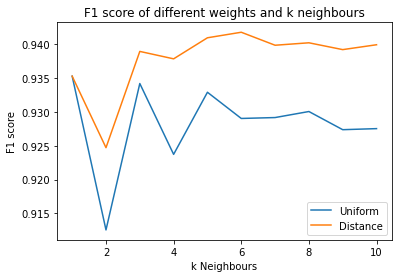

In [49]:
plt.Figure(figsize=(5,5))
plt.title("F1 score of different weights and k neighbours")
plt.xlabel('k Neighbours')
plt.ylabel('F1 score')
x=[1,2,3,4,5,6,7,8,9,10]
plt.plot(x,f1[1:11])
plt.plot(x,f1[12:22])
plt.legend(['Uniform','Distance'])

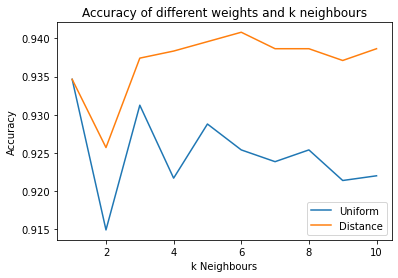

In [50]:
plt.Figure(figsize=(5,5))
plt.title("Accuracy of different weights and k neighbours")
plt.xlabel('k Neighbours')
plt.ylabel('Accuracy')
plt.plot(x,acc[1:11])
plt.plot(x,acc[12:22])
plt.legend(['Uniform','Distance'])

<h3>Decision tree</h3>

In [134]:
split_data(X, y)

f1 = []
acc = []
best_fold = []
t= ["best","random"]
s= ["entropy","gini"]
for i in range(len(s)):
    for j in range(len(t)):
        model = DecisionTreeClassifier(random_state=42, splitter=t[i], criterion=s[j])
        model_results(model, d=False)

In [135]:
f1
f1_remake = [[f1[0],f1[1]],[f1[2],f1[3]]]

acc
acc_remake = [[acc[0],acc[1]],[acc[2],acc[3]]]

Text(33.0, 0.5, 'Criterion')

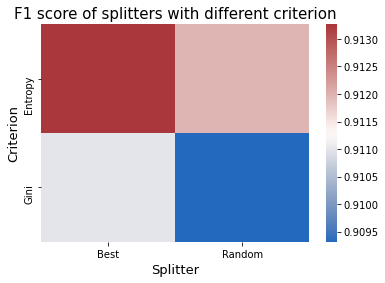

In [136]:
x_axis_labels = ["Best","Random"]
y_axis_labels = ["Entropy","Gini"]

sns.heatmap(f1_remake, cmap="vlag", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

plt.title("F1 score of splitters with different criterion", fontsize=15)
plt.xlabel('Splitter', fontsize=13)
plt.ylabel('Criterion', fontsize=13)

Text(33.0, 0.5, 'Criterion')

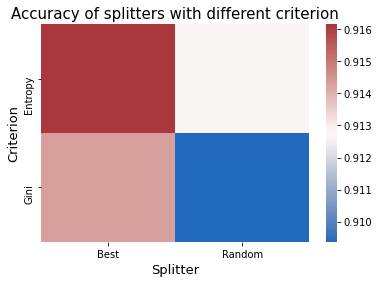

In [137]:
x_axis_labels = ["Best","Random"]
y_axis_labels = ["Entropy","Gini"]

sns.heatmap(acc_remake, cmap="vlag", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

plt.title("Accuracy of splitters with different criterion", fontsize=15)
plt.xlabel('Splitter', fontsize=13)
plt.ylabel('Criterion', fontsize=13)

In [141]:
f1 = []
acc = []
best_fold = []
for i in range(2,16):
    model = DecisionTreeClassifier(splitter="best", criterion="entropy", min_samples_split=i)
    model_results(model, d=False)
    

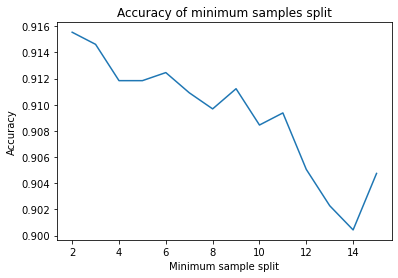

In [142]:
x=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.Figure(figsize=(5,5))
plt.title("Accuracy of minimum samples split")
plt.xlabel('Minimum sample split')
plt.ylabel('Accuracy')
plt.plot(x,acc)

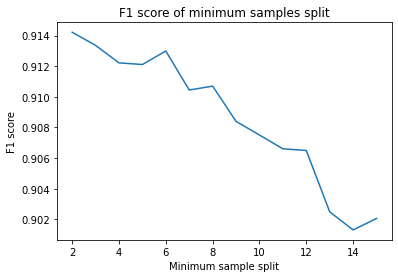

In [143]:
plt.Figure(figsize=(5,5))
plt.title("F1 score of minimum samples split")
plt.xlabel('Minimum sample split')
plt.ylabel('F1 score')
plt.plot(x,f1)

<h3>Logistic Regression</h3>

In [155]:
split_data(X, y)

f1 = []
acc = []
best_fold = []
t= ["newton-cg","lbfgs","liblinear","sag","saga"]
for i in range(len(t)):
    model = LogisticRegression(max_iter=1000, random_state=42, solver=t[i])
    model_results(model, d=False)

<BarContainer object of 5 artists>

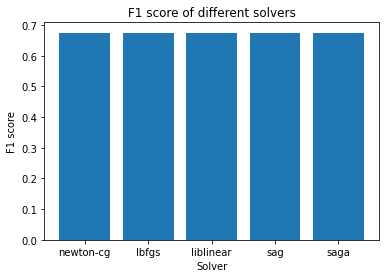

In [156]:
plt.Figure(figsize=(5,5))
plt.title("F1 score of different solvers")
plt.xlabel('Solver')
plt.ylabel('F1 score')
plt.bar(t,f1)

<BarContainer object of 5 artists>

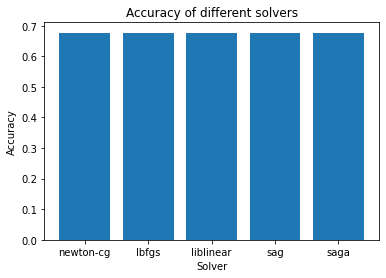

In [159]:
plt.Figure(figsize=(5,5))
plt.title("Accuracy of different solvers")
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.bar(t,acc)

In [172]:
f1 = []
acc = []
best_fold = []
t= ["l1","l2"]
for i in range(len(t)):
    model = LogisticRegression(max_iter=1000, random_state=42, solver="liblinear",penalty=t[i])
    model_results(model, d=False)

<BarContainer object of 2 artists>

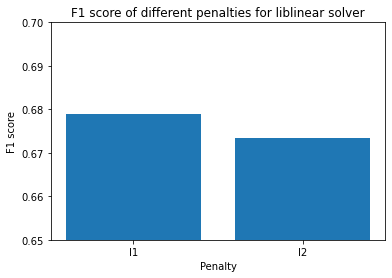

In [180]:
plt.Figure(figsize=(5,5))
plt.title("F1 score of different penalties for liblinear solver")
plt.xlabel('Penalty')
plt.ylabel('F1 score')
plt.ylim(0.65,0.7)
plt.bar(t,f1)

<BarContainer object of 2 artists>

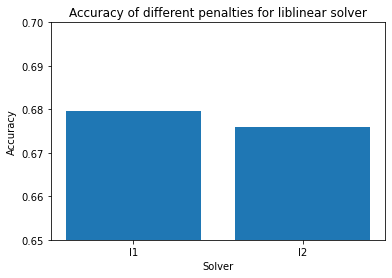

In [179]:
plt.Figure(figsize=(5,5))
plt.title("Accuracy of different penalties for liblinear solver")
plt.xlabel('Penalty')
plt.ylabel('Accuracy')
plt.ylim(0.65,0.7)
plt.bar(t,acc)

In [175]:
f1

[0.6790237874575225, 0.673298103823438]

In [176]:
acc

[0.6797163995067818, 0.6760172626387176]

<h3>Naive Bayes</h3>

In [187]:
split_data(X, y)

f1 = []
acc = []
best_fold = []
t= [1e-9,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for i in range(len(t)):
    model = GaussianNB()
    model_results(model, d=False)

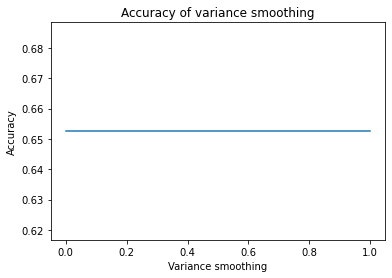

In [190]:
plt.Figure(figsize=(5,5))
plt.title("Accuracy of variance smoothing")
plt.xlabel('Variance smoothing')
plt.ylabel('Accuracy')
plt.plot(t,acc)

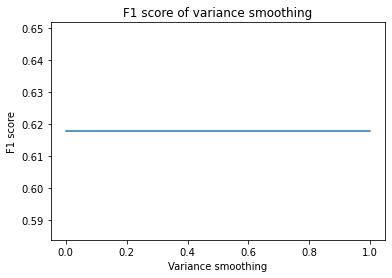

In [191]:
plt.Figure(figsize=(5,5))
plt.title("F1 score of variance smoothing")
plt.xlabel('Variance smoothing')
plt.ylabel('F1 score')
plt.plot(t,f1)

In [193]:
acc

[0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449,
 0.6525893958076449]

<h3>Multi-layer Perceptron classifier</h3>

In [202]:
split_data(X, y)

f1 = []
acc = []
best_fold = []

s = ((25,25),(50,50),(75,75),(100,100),(125,125))

for i in range(len(s)):
    print(i)
    model = MLPClassifier(max_iter=1000, random_state=42, hidden_layer_sizes=s[i])
    model_results(model, d=False)

0
1
2
3
4


In [208]:
acc_1 = [0.7894574599260172, 0.8079531442663379, 0.8341553637484587, 0.8535758323057954, 0.846177558569667]
f1_1 = [0.7989402413894614, 0.8174626428362144, 0.8408284023668638, 0.8633093525179856, 0.8522357121705657]

acc_2 = [0.8301479654747226, 0.8622071516646116, 0.909062885326757, 0.8961159062885327, 0.9180024660912454]
f1_2 = [0.8243544788014027, 0.8658865886588659, 0.9121239201668155, 0.9026292978907831, 0.9208804283164783]

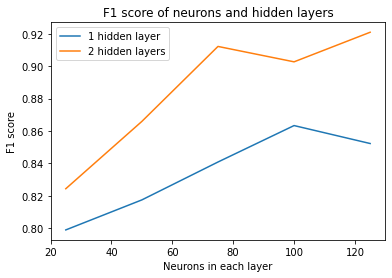

In [213]:
plt.Figure(figsize=(5,5))
plt.title("F1 score of neurons and hidden layers")
plt.xlabel('Neurons in each layer')
plt.ylabel('F1 score')
x = [25,50,75,100,125]
plt.plot(x,f1_1)
plt.plot(x,f1_2)
plt.legend(['1 hidden layer','2 hidden layers'])

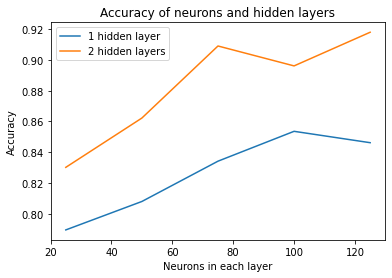

In [214]:
plt.Figure(figsize=(5,5))
plt.title("Accuracy of neurons and hidden layers")
plt.xlabel('Neurons in each layer')
plt.ylabel('Accuracy')
plt.plot(x,acc_1)
plt.plot(x,acc_2)
plt.legend(['1 hidden layer','2 hidden layers'])

In [215]:
split_data(X, y)

f1 = []
acc = []
best_fold = []
s = ["identity","logistic","tanh"]

for i in range(len(s)):
    print(i)
    model = MLPClassifier(max_iter=1000, random_state=42, hidden_layer_sizes=(75,75), activation=s[i])
    model_results(model, d=False)

0
1


C:\Users\olive\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


2


In [229]:
#f1.append(0.909062885326757)
#acc.append(0.9121239201668155)
x = ["Indentity","Logistic","Tanh","Relu"]
acc

[0.6831072749691739, 0.781442663378545, 0.9210850801479655, 0.9121239201668155]

[0.690734055354994, 0.7866385795967499, 0.9254079254079253, 0.909062885326757]

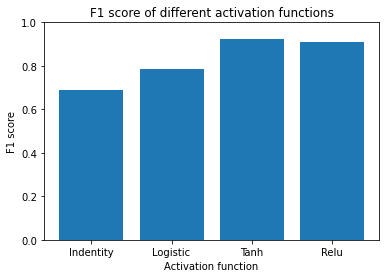

In [227]:
plt.Figure(figsize=(5,5))
plt.title("F1 score of different activation functions")
plt.xlabel('Activation function')
plt.ylabel('F1 score')
plt.ylim(0.0,1.0)
plt.bar(x,f1)
f1

<BarContainer object of 4 artists>

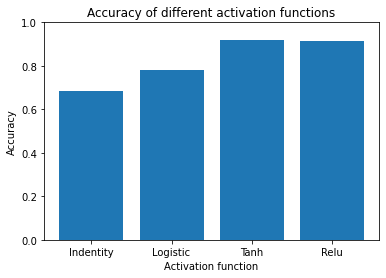

In [228]:
plt.Figure(figsize=(5,5))
plt.title("Accuracy of different activation functions")
plt.xlabel('Activation function')
plt.ylabel('Accuracy')
plt.ylim(0.0,1.0)
plt.bar(x,acc)